<a href="https://colab.research.google.com/github/wjdgoruds2/Machine_Learning/blob/main/Assignment13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**RUN의 동작**

In [ ]:
import torch#pytorch사용
import torch.nn as nn#신경망 사용
import torch.nn.functional as F

class SimpleRNN(nn.Module):
  def __init__(self,batch_size,n_inputs,n_neurons,n_outputs):
    super(SimpleRNN,self).__init__()#각 레이어들을 정의
    self.U=torch.randn(n_inputs,n_neurons)#입력->은닉 가중치
    self.W=torch.randn(n_neurons,n_neurons)#은닉->은닉 가중치
    self.V=torch.randn(n_neurons,n_outputs)#은닉->출력 가중치
    self.h=torch.randn(batch_size,n_neurons)#은닉층
    self.b=torch.zeros(1,n_neurons)#은닉층 계산을 위한 편향
    self.c=torch.zeros(1,n_outputs)#출력층 계산을 위한 편향
  def forward(self,X):
    s=torch.mm(X,self.U)+torch.mm(self.h,self.W)+self.b#입력->은닉 가중치,은닉->은닉 가중치,은닉층 계산을 위한 편향을 통해 은닉층을 위한 값 계산
    self.h=torch.tanh(s)#은닉층 계산
    o=torch.mm(s,self.V)+self.c#은닉->출력 가중치,출력층 계산을 위한 편향을 통해 출력층을 위한 값 계산
    f=F.softmax(o,dim=0)#출력층 계산
    return f,self.h#출력층과 은닉층 반환

n_input=3;n_neurons=5;n_output=2;batch_size=4#입력,출력,n_neurons 수,한번에 넘기는 데이터 크기 설정
model=SimpleRNN(batch_size,n_input,n_neurons,n_output)#RNN계산
temp=[[[0,1,2],[3,4,5],[6,7,8],[9,0,1]],[[9,8,7],[0,0,0],[6,5,4],[3,2,1]]]#현재 배열 설정
batch=torch.tensor(temp,dtype=torch.float)#temp배열을 tensor로 변환

for i in range(2):
  output,hidden_state=model(batch[i])#현재 배열 temp RNN시킨 출력과 은닉 tensor
  print('output:',output)#출력층 tensor출력
  print('hidden state:',hidden_state)#은닉층 tensor출력


output: tensor([[2.4247e-27, 9.4970e-07],
        [9.4152e-29, 5.1237e-03],
        [8.0834e-35, 9.9488e-01],
        [1.0000e+00, 1.7156e-12]])
hidden state: tensor([[ 0.3646,  0.6920,  0.9295,  1.0000,  0.9919],
        [ 0.8487, -1.0000,  0.9601,  1.0000,  1.0000],
        [-0.9143, -1.0000,  0.8548,  1.0000,  1.0000],
        [ 0.9928, -1.0000, -1.0000,  0.9876, -1.0000]])
output: tensor([[2.5839e-14, 9.4434e-01],
        [9.9718e-01, 1.3423e-06],
        [3.3635e-08, 5.5661e-02],
        [2.8207e-03, 9.0243e-07]])
hidden state: tensor([[-1.0000, -1.0000, -0.9891,  1.0000,  0.9991],
        [ 0.9976,  0.3904, -0.9420, -0.9896, -0.9419],
        [-0.6669, -1.0000, -0.6790,  1.0000,  0.8979],
        [-0.2832, -1.0000, -0.9653, -0.9294, -0.7651]])


**RNN을 이용한 언어 모델**

In [ ]:
from google.colab import files
myfile = files.upload()

Saving korean_bible.txt to korean_bible (2).txt


In [ ]:
import numpy as np#배열 사용

data=open('korean_bible (2).txt','rt',encoding='cp949').read()#korean_bible.txt 파일 열기
chars=list(set(data))#data내용 리스트화
data_size,vocab_size=len(data),len(chars)#데이터 사이즈와 문자 개수 설정
print('전체 문자 개수:%d,구별되는 문자 개수:%d'%(data_size,vocab_size))#전체 문자 개수,문자 개수 출력

char_to_ix={ch:i for i,ch in enumerate(chars)}# 고유한 글자들(a,b,c,d...)을 숫자(1,2,3,4...)에 매핑하는 사전
ix_to_char={i:ch for i,ch in enumerate(chars)}#반대 기능을 수행하는 사전
print(char_to_ix)#글자:숫자 출력
print(ix_to_char)#숫자:글자 출력

hidden_size=100# hidden state의 뉴런 갯수
seq_length=25# 학습시킬 때 한번에 불러올 글자 수이자 RNN을 펼쳤을 때의 단계
learning_rate=1e-1# 학습속도, 가중치를 조정할 때 이동할 간격

U=np.random.randn(hidden_size,vocab_size)*0.01#입력->은닉 가중치(100,25)
W=np.random.randn(hidden_size,hidden_size)*0.01#은닉->은닉 가중치(100,100)
V=np.random.randn(vocab_size,hidden_size)*0.01#은닉->출력 가증치(25,100)
b=np.zeros((hidden_size,1))#은닉 편향(100,1)
c=np.zeros((vocab_size,1))#출력 편향(25,1)

def evalLossGradientHstate(inputs,targets,hprev):
  xs,hs,os,ys={},{},{},{}
  hs[-1]=np.copy(hprev)
  loss=0

  for t in range(len(inputs)):
    xs[t]=np.zeros((vocab_size,1))# 1-of-k(one-hot) 형태로 변환. 모든 값이 0인 array 준비
    xs[t][inputs[t]]=1# 해당하는 글자에만 값을 1
    hs[t]=np.tanh(np.dot(U,xs[t])+np.dot(W,hs[t-1])+b)#은닉상태 업데이트
    os[t]=np.dot(V,hs[t])+c# 다음 글자가 어떤 글자가 나올지에 가능성을 표시한 array
    ys[t]=np.exp(os[t])/np.sum(np.exp(os[t]))#softmax로 각 글자의 등장 가능성을 확률로 표시
    loss+=-np.log(ys[t][targets[t],0])#cross-entropy를 이용하여 정답과 비교하여 손실값 판정
 
  dU,dW,dV= np.zeros_like(U), np.zeros_like(W), np.zeros_like(V)# 변수 초기화
  db,dc=np.zeros_like(b), np.zeros_like(c)# 변수 초기화
  dhh= np.zeros_like(hs[0])# 변수 초기화
  for t in reversed(range(len(inputs))): #forward pass의 과정을 반대로 진행(t=24부터 시작)
    do=np.copy(ys[t])
    do[targets[t]] -= 1 # y의 그래디언트 계산, softmax 함수의 그래디언트 계산
    dV+=np.dot(do,hs[t].T) 
    dc+=do
    dh=np.dot(V.T,do)+dhh # loss에서 사용된 h와 h를 업데이트한 계산의 그래디언트 값을 더함
    dhHs=(1-hs[t]*hs[t])*dh # tanh 역전파
    db+=dhHs
    dU+=np.dot(dhHs,xs[t].T)
    dW+=np.dot(dhHs,hs[t-1].T)
    dhh=np.dot(W.T, dhHs)
  for dparam in [dU,dW,dV,db,dc]:
    np.clip(dparam,-5,5,out=dparam) # 그래디언트 발산 방지
  return loss,dU,dW,dV,db,dc,hs[len(inputs)-1]

def generateText(h, seed_ix, n):
  x = np.zeros((vocab_size, 1))#vocab_size,1 배열 초기화
  x[seed_ix] = 1#첫번째 글자 1로 설정

  ixes = []#결과 배열
  for t in range(n):
    # forward pass 수행
    h = np.tanh(np.dot(U,x) + np.dot(W, h) + b)#은닉층 계산
    o = np.dot(V, h) + c#출력층 계산
    y = np.exp(o) / np.sum(np.exp(o))
    ix = np.random.choice(range(vocab_size), p=y.ravel()) # 샘플링. 임의성을 부여하기 위해 argmax대신 array p에서 주어진 확률에 의해 하나의 문자를 선택
    x = np.zeros((vocab_size, 1)) # 다음 글자 추론을 위해 샘플링 된 글자를 다음 입력으로 사용 
    x[ix] = 1
    ixes.append(ix) # 결과값 리스트에 추가
  txt=''.join(ix_to_char[ix] for ix in ixes)
  print('----\n %s \n----' % (txt, ))

print('학습 전 모델의 문자 생성')
hprev=np.zeros((hidden_size,1))
generateText(hprev,0,200)

n, p = 0, 0 #  반복 회수(n) 및 입력 데이터(p) 위치 초기화 

# Adagrad 알고리즘에 사용되는 메모리 변수 초기화
mU,mW,mV= np.zeros_like(U), np.zeros_like(W), np.zeros_like(V)
mb,mc = np.zeros_like(b), np.zeros_like(c) 
smooth_loss = -np.log(1.0/vocab_size)*seq_length # 학습이 이루어지기 전의 손실값
while n<= 1000*1500:
  # 입력데이터 준비, 텍스트의 맨 앞쪽부터 seq_length만큼씩 데이터를 준비
  # 데이터를 모두 사용하면 입력 데이터의 맨 처음으로 이동
  if p+seq_length+1 >= len(data) or n == 0: 
    hprev = np.zeros((hidden_size,1)) # RNN 메모리 초기화
    p = 0 # 입력 데이터의 맨 처음으로 이동
  
  # 입력(p~p+24번째 글자), 목표(p+1~p+25번째 글자) 데이터를 준비 
  inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
  targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

  # 손실함수에서 손실값과 그래디언트를 함께 계산
  loss,dU,dW,dV,db,dc,hprev = evalLossGradientHstate(inputs, targets, hprev)
  smooth_loss = smooth_loss * 0.999 + loss * 0.001
  
  # 학습을 5000번 반복할 때마다 학습 결과를 출력
  if n % 5000 == 0:
    print('iter %d,loss:%f'%(n,smooth_loss)) # 반복횟수, 손실 출력
    generateText(hprev,inputs[0],200) #지금까지 학습한 RNN을 이용하여 숫자의 리스트를 출력
  
  # Adagrad 방식으로 파라미터 업데이트
  for param, dparam, mem in zip([U,W,V,b,c],   # 가중치
                                [dU,dW,dV,db,dc],  # 그래디언트
                                [mU,mW,mV,mb,mc]): # 메모리 
    mem += dparam * dparam
    param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # 실제 파라메터 업데이트

  p += seq_length # 데이터 포인터를 seq_length만큼 우측으로 이동
  n += 1 # 반복횟수 카운터

전체 문자 개수:5432012,구별되는 문자 개수:1294
{'셨': 0, '육': 1, '옴': 2, '별': 3, '좽': 4, '뜬': 5, '혐': 6, '뚤': 7, '얘': 8, '델': 9, '뭇': 10, '레': 11, '쓸': 12, '존': 13, '격': 14, '윔': 15, '둥': 16, '푼': 17, '덱': 18, '뢰': 19, '홧': 20, '꼬': 21, '였': 22, '샅': 23, '짊': 24, '겪': 25, '붊': 26, '퀴': 27, '굵': 28, '뇌': 29, '매': 30, '줌': 31, '빌': 32, '헤': 33, '벽': 34, '운': 35, '워': 36, '시': 37, '괜': 38, '흰': 39, '항': 40, '숟': 41, '잎': 42, '덩': 43, '락': 44, '덫': 45, '삶': 46, '찌': 47, '해': 48, 'e': 49, '실': 50, '울': 51, '밑': 52, '띠': 53, '끈': 54, '줏': 55, '딱': 56, '닌': 57, '뻑': 58, '중': 59, '륜': 60, '랏': 61, '쏨': 62, '룽': 63, '윌': 64, '흉': 65, '볍': 66, '돋': 67, '렁': 68, '오': 69, '릎': 70, '깥': 71, '딤': 72, '뒷': 73, '로': 74, '사': 75, '덕': 76, '볼': 77, '갖': 78, '싯': 79, '흥': 80, '징': 81, '씬': 82, '에': 83, '!': 84, '창': 85, '늠': 86, 'k': 87, '메': 88, '으': 89, '쟀': 90, '것': 91, '축': 92, '홋': 93, 'i': 94, '씹': 95, '훅': 96, '릿': 97, '번': 98, '습': 99, '잊': 100, '칠': 101, '땅': 102, '쁨': 103, '혹': 104, '윙': 105, '어': 106, '른': 1

KeyboardInterrupt: ignored

**LSTM기반 주가 예측**

In [ ]:
import requests#http요청 모듈
import numpy as np#배열 설정
import matplotlib.pyplot as plt#시각화 위함
from urllib.request import urlopen#url열기
from bs4 import BeautifulSoup#크롤링
html=urlopen('https://finance.naver.com/item/sise_day.nhn?code=005930&page=1')#크롤링할 url설정
bsObject=BeautifulSoup(html,"html.parser")#html 크롤링
quotations_links=[]#일별 시세 url저장
closingPrices=[]#종가
quotations=[]#시가
highPrices=[]#고가
lowPrices=[]#저가
closingPricesfloat=[];lowPricesfloat=[];highPricesfloat=[];quotationsfloat=[]#종가,시가,고가,저가 배열 초기화

for cover in bsObject.find_all('tabel',{'summary':'페이지 네비게이션 리스트'}):
  for i in range(0,10,10):
    quotations_links.append('https://finance.naver.com'+cover.select('a')[i].get('href'))#<a>태크의 링크를 찾아quotations_links에 저장

for index,quotations_link in enumerate(quotations_links):
  html=urlopen(quotations_link)#quotations_link를 열기
  bsObject=BeautifulSoup(html,"html.parser")#html 크롤링
  for i in range(2,70,7):#2부터 70까지 7의 간격으로
    closingPrice=bsObject.select('span')[i].text#span태그위치의 내용
    closingprices.append(closingPrice)#closingprices에 closingPrice더함
  for i in range(4,70,7):#4부터 70까지 7의 간격으로
    quotation=bsObject.select('span')[i].text#span태그위치의 내용
    quotations.append(quotation)#quotations에 quotation더함
  for i in range(5,70,7):#5부터 70까지 7의 간격으로
    highPrice=bsObject.select('span')[i].text#span태그위치의 내용
    highPrices.append(highPrice)#highPrices에 highPrice더함
  for i in range(6,70,7):#6부터 70까지 7의 간격으로
    lowPrice=bsObject.select('span')[i].text#span태그위치의 내용
    lowPrices.append(lowPrice)#lowPricess에 lowPrice더함

xy=[[0]*4 for i in range(100)]# 배열에 종가 저가 시가 넣기

#,떼기
for i in range(100):
  num=int(closingPrices[i].replace(',',''))#closingPrices에서 ,을 공백으로
  closingPricesfloat.append(num)#closingPricesfloat에 num저장
  [i][0]=closingPricesfloat[i]#xy배열 첫번째에 closingPricesfloat

for i in range(100):
  num=int(lowPrices[i].replace(',',''))#lowPrices에서 ,을 공백으로
  lowPricesfloat.append(num)#lowPricesfloat에 num저장
  xy[i][1]=lowPricesfloat[i]#xy배열 두번째에 lowPricesfloat

for i in range(100):
  num=int(highPrices[i].replace(',',''))#highPrices에서 ,을 공백으로
  highPricesfloat.append(num)#highPricesfloat에 num저장
  xy[i][2]=highPricesfloat[i]#xy배열 세번째에 highPricesfloat

for i in range(100):
  num=int(quotations[i].replace(',',''))#quotations에서 ,을 공백으로
  quotationsfloat.append(num)#quotationsfloat에 num저장
  xy[i][3]=quotationsfloat[i]#xy배열 네번째에 quotationsfloat

xy=xy[::-1]#역순으로 저장

seq_length=7#시계열 데이터 입력 개수
train_size = int(len(xy) * 0.7) #전체 70%
train_set = xy[0:train_size]#전체 70%를 학습용 데이터로 사용
test_set = xy[train_size - seq_length:]  # 나머지30%를 테스트용 데이터로 사용

print('trainX:',trainX.shape,'trainY:',trainY.shape)#trainX,trainY차원 출력
print(train_set[0:5])#train_set의 처음부터5개 출력

def build_dataset(time_series, seq_length):
  dataX = []#dataX배열 초기화
  dataY = []#dataY배열 초기화
  for i in range(0, len(time_series) - seq_length):
      _x = time_series[i:i + seq_length, :]#seq_length까지 출력
      _y = time_series[i + seq_length, [-1]] #다음 나타날 주가
      print(_x, "->", _y)#첫번째 행만 출력
      dataX.append(_x)#dataX 리스트에 추가
      dataY.append(_y)#dataY리스트에 추가
  return np.array(dataX), np.array(dataY)#dataX,dataY배열 반환

trainX, trainY = build_dataset(train_set, seq_length)#학습 데이터 설정
testX, testY = build_dataset(test_set, seq_length)#테스트 데이터 설정

print('trainX:',trainX.shape,'trainY:',trainY.shape)#trainX,trainY 차원 출력
print('testX:',testX.shape,'testY:',testY.shape)#testX,testY 차원 출력
print(trainX[0],'->',trainY[0])

import torch#pytorch사용
import torch.optim as optim# optimizer 사용 정의
import numpy as np#배열 사용
import matplotlib.pyplot as plt#시각화 위함

trainX_tesnsor=torch.FloatTensor(trainX)#trainX를 32-bit floating
trainY_tesnsor=torch.FloatTensor(trainY)#trainY를 32-bit floating

testX_tesnsor=torch.FloatTensor(testX)#testX를 32-bit floating
testY_tesnsor=torch.FloatTensor(testY)#testY를 32-bit floating

class Net(torch.nn.Module):#신경망을 정의
  def __init__(self,input_dim,hidden_dim,output_dim,layers):
    super(Net,self).__init__()#각 레이어들을 정의
    self.rnn=torch.nn.LSTM(input_dim,hidden_dim,num_layers=layers,batch_first=True)#입력,내부 변환 사이즈,층 개수,batch가 0번 차원
    self.fc=torch.nn.Linear(hidden_dim,output_dum,bias=True)#입력과 출력,편향 설정->선형회귀
  def forward(self,x):
    x,_status=self.rnn(x)
    x=self.fc(x[:,-1])
    return x

data_dim=4#입력차원
hidden_dim=150#은닉차원
output_dim=1#출력차원
learning_rate=0.01#learning_rate설정
iterations=5000#반복회수 설정

net=Net(data_dim,hidden_dim,output_dim,1)#신경망 설정

criteion=torch.nn.MSELoss()#MSELoss통해 손실함수 정의
optimizer=optim.Adam(net.parameters(),lr=learning_rate)#다음 파라미터를 업데이트 하기위해 최적화 함수를 정의

for i in range(iterations+1):
  optimizer.zero_grad()#optimizer 초기화
  outputs=net(trainX_tesnsor)#net에 trainX_tesnsor넣어서 outputs 나오기
  loss=criterion(outputs,trainY_tensor)#outputs으로 loss계산
  loss.backward()#loss를 기준으로 미분 자동계산
  optimizer.step()#optimizer계산
  if i%500 == 0:#500번씩 출력
    print('iteration:',i,'loss:',loss.item())#반복회수와 손실도 출력
net.eval()#평가모드로 설정
with torch.no_grad():
  predictY=net(testX_tensor)#예측치 계산

plt.plot(testY)#true 값 파란색
plt.plot(predictY) #예측한 값 주황색
plt.lengend(['original','predict'])
plt.show()#그래프 출력


IndexError: ignored

**RNN을 이용한 감성분석**

In [1]:
!pip install pyprind#pyprind모듈 다운
import pyprind#progress bar를 시각적
import pandas as pd#데이터 분석
from string import punctuation#구두점 제거
import numpy as np#배열 사용

df=pd.read_csv('movie_data.csv',encoding='utf-8')#movie_data.csv읽어옴
print(df.head())

from collections import Counter#자료개수파악
counts=Counter()#개수개체 정의
pbar=pyprind.ProgBar(len(df['review']),title='단어 발생 횟수')#progress bar

for i,review in enumerate(df['review']):
  text=''.join([c if c not in punctuation else ''+c+'' for c in review]).lower()#구두점제거,소문자 변환
  df.loc[i,'review']=text#i,'review' 단어 선택
  pbar.update()#pbar업데이트
  counts.update(text.split())#단어를 나눠 회수 업데이트
print(df.head())

word_counts=sorted(counts,key=counts.get,reverse=True)#단어개수
word_to_int={word:idx for idx,word in enumerate(word_counts,1)}#각 고유 단어를 고유한 정수 번호로 매핑
mapped_reviews = []
pbar=pyprind.ProgBar(len(df['review']),title='review의 정수열 변환')#progress bar

for review in df['review']:
  mapped_reviews.append([word_to_int[word] for word in review.split()])#문장의 정수열 변환
print(mapped_reviews[0])#첫번쨰mapped_reviews 출력

sequence_length=200#서열 길이
sequences=np.zeros((len(mapped_reviews),sequence_length),dtype=int)#동일 길이의sequences 만듬

for i,row in enumerate(mapped_reviews):
  review_arr=np.array(row)
  sequences[i,-len(row):]=review_arr[-sequence_length:]#시퀀스 길이가 200보다 작으면 왼쪽에 0이 패딩,시퀀스 길이가 200보다 크면 마지막 200개 원소만 사용

X_train=sequences[:37500,:]#0부터37500개
y_train=df.loc[:37500,'sentiment'].values#0부터37500개의 sentiment값
X_test=sequences[37500:,:]#37500부터 끝까지
y_test=df.loc[37500:,'sentiment'].values#37500부터 끝까지 sentiment값

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)#X_train,y_train,X_test,y_test차원 출력
n_words = len(word_to_int) + 1#구별된 단어 개수
print('no. of distinct words :',n_words)#구별된 단어 개수 출력

from tensorflow.keras import models, layers#keras모델과 추상화
model = models.Sequential()#입력 형태 지정
model.add(layers.Embedding(n_words, 200,embeddings_regularizer='l2'))#embeddings matrix추가
model.summary()

model.add(layers.LSTM(16))#16개인LSTM계층 추가
model.add(layers.Flatten())#다차원 1차원으로 바꿈
model.add(layers.Dense(1, activation='sigmoid'))#sigmoid함수로 1개 Dense계층 추가
model.summary()

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['acc'])#loss,optimizer,metrics선택하여 keras설정
import time#시간 다룸
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard#TensorBoard로 훈련 진행 상황과 결과를 시각화,모델 주기적 저장

callback_list = [ModelCheckpoint(filepath='sentiment_rnn_checkpoint.h5',monitor='val_loss', 
                                 save_best_only=True), TensorBoard(log_dir="sentiment_rnn_logs/{}".format(int(time.time()%100)))]#Keras에서 모델을 학습할 때마다 중간중간에 콜백 형태로 알려줌
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.3, callbacks=callback_list)  #모델 학습

import matplotlib.pyplot as plt#시각화 위함
epochs = np.arange(1, 11)#1부터 10번반복
plt.plot(epochs, history.history['loss'])#loss시각화
plt.plot(epochs, history.history['val_loss'])#val_loss시각화
plt.xlabel('epochs')#xlabel설정
plt.ylabel('loss')#ylabel설정
plt.show()#그래프 보여줌

epochs = np.arange(1, 11)#1부터 10번반복
plt.plot(epochs, history.history['acc'])#acc시각화
plt.plot(epochs, history.history['val_acc'])#val_loss시각화
plt.xlabel('epochs')#xlabel설정
plt.ylabel('loss')#ylabel설정
plt.show()#그래프 보여줌

model.load_weights('sentiment_rnn_checkpoint.h5')#로드한 모델에 Weight 로드
model.evaluate(X_test, y_test)#모델 평가 

print(model.predict(X_test[:10]))#처음부터 10개 예측값 출력
print((model.predict(X_test[:10])>0.5).astype('int32'))#0.5큰 예측값 32비트 정수형으로 출력

FileNotFoundError: ignored

**LSTM구현**

In [ ]:
from google.colab import files
myfile = files.upload()

Saving cansim-0800020-eng-6674700030567901031.csv to cansim-0800020-eng-6674700030567901031 (2).csv


  Adjustments  Unadjusted  Seasonally adjusted
0    Jan-1991    12588862             15026890
1    Feb-1991    12154321             15304585
2    Mar-1991    14337072             15413591
3    Apr-1991    15108570             15293409
4    May-1991    17225734             15676083
             Unadjusted  Seasonally adjusted
Adjustments                                 
1991-01-31     12588862             15026890
1991-02-28     12154321             15304585
1991-03-31     14337072             15413591
1991-04-30     15108570             15293409
1991-05-31     17225734             15676083
[[0.01402033]
 [0.        ]
 [0.0704258 ]
 [0.09531795]
 [0.16362761]]
               Scaled
Adjustments          
1991-01-31   0.014020
1991-02-28   0.000000
1991-03-31   0.070426
1991-04-30   0.095318
1991-05-31   0.163628
               Scaled   shift_1   shift_2  ...  shift_10  shift_11  shift_12
Adjustments                                ...                              
1991-01-31   0.014020   

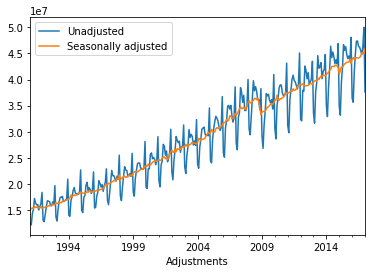

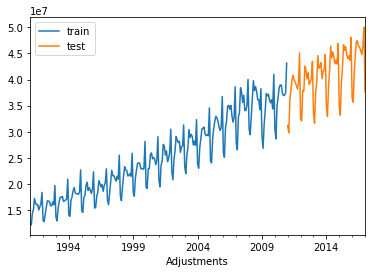

In [ ]:
import pandas as pd#데이터 분석
import numpy as np#배열 사용
%matplotlib inline
import matplotlib.pyplot as plt#시각화 위함

df = pd.read_csv('cansim-0800020-eng-6674700030567901031 (2).csv',skiprows=6, skipfooter=9,engine='python')#cansim-0800020-eng-6674700030567901031 (2).csv파일 읽어옴
print(df.head())

from pandas.tseries.offsets import MonthEnd #해당 월의 맨 끝 날짜
df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1) #Adjustments 변수를 datetime 객체로 만들고 MonthEnd(1)더해 해당 월의 맨끝 날짜 지정
df = df.set_index('Adjustments') #해당 날짜를 index로 지정
print(df.head()) 
df.plot()#Unadjusted와 Seasonally adjusted 변수의 그래프

split_date = pd.Timestamp('01-01-2011')#2011/1/1을 기준으로 나눔

train = df.loc[:split_date, ['Unadjusted']]#2011/1/1 까지의 데이터를 학습데이터셋
test = df.loc[split_date:, ['Unadjusted']]# 그 이후 데이터를 테스트데이터셋

ax = train.plot()#train을 시각화
test.plot(ax=ax)#test를 시각화
plt.legend(['train', 'test'])#범례설정

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()#MinMax Scaling을 통해 변수를 Scaling
train_sc = sc.fit_transform(train)#train Scaling
test_sc = sc.transform(test)#test Scaling
print(train_sc[0:5])#스케일링된 train_sc 처음부터 5개 출력

train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)#train_sc을 dataframe 데이터 타입으로 변환
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)#test_sc을 dataframe 데이터 타입으로 변환
print(train_sc_df.head())

for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)#train_sc_df의 과거값은 총 12개를 저장
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)#test_sc_df의 과거값은 총 12개를 저장
print(train_sc_df.head(7))#7개의 shift1~12를 통해 현재값 Scaled를 예측값 출력

X_train = train_sc_df.dropna().drop('Scaled', axis=1)#NaN이 있는 데이터를 제거shift_1 ~ shift_12는 X로 Scaled는 Y로 지정
y_train = train_sc_df.dropna()[['Scaled']]#NaN이 있는 데이터를 제거,shift_1 ~ shift_12는 X로 Scaled는 Y로 지정
X_test = test_sc_df.dropna().drop('Scaled', axis=1)#NaN이 있는 데이터를 제거,shift_1 ~ shift_12는 X로 Scaled는 Y로 지정
y_test = test_sc_df.dropna()[['Scaled']]#NaN이 있는 데이터를 제거,shift_1 ~ shift_12는 X로 Scaled는 Y로 지정
print(X_train.head())